In this script the most important pathways and senescence were summerized. Then the data was prepared for fitting. 
1. Cell cycle arrest (p38MAPK)
2. NF-kB
3. SASP
4. Senescence
5. Merge data and add insert theoretical dose
6. Insert empty replicates
7. Scaling

In [31]:
# to show plots:
show = True

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import numpy as np
import seaborn as sns
import scanpy as sc
import scanpy.external as se
from itertools import product
import anndata as ad
import plotly.graph_objects as go
import matplotlib.cm as cm

sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.5
-----
PIL                 9.4.0
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.5
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
executing           0.8.3
h5py                3.9.0
hypergeom_ufunc     NA
igraph              0.10.8
invgauss_ufunc      NA
ipykernel           6.25.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
llvmlite            0.40.1
louvain             0.8.1
matplotlib          3.7.2
matplotlib_inline   0.1.6
mkl                 2.4.0
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
ncf_ufunc           NA
nct_ufunc           NA
ncx2_ufunc          NA
numba               0.57.1
numexpr             2.8.4
numpy               1.24.3
packaging           23.1
pandas           

Import and check data set that was already scored with senepy

In [33]:
adata = ad.read_h5ad('YOURFOLDER/all_sen_score.h5ad')
adata.obs['cell_type'].value_counts()

cell_type
Kupffer cell                            1932
hepatocyte                              1614
endothelial cell of hepatic sinusoid     155
Name: count, dtype: int64

In [34]:
age_counts = adata.obs['age'].value_counts()
age_counts

age
30m    1773
3m     1021
18m     515
21m     289
24m     103
Name: count, dtype: int64

1. Cell cycle arrest (p38MAPK)

In [1]:
gene_names = ['Map2k3','Mapk14', 'Trp53', 'Cdkn1a', 'E2f4']

In [36]:
mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

    genes_per_mouse = pd.concat([genes_per_mouse, expression_per_timepoint], ignore_index=True)

# mean of all genes per mouse
genes_per_mouse.drop(['Numeric_time', 'Gene', 'Timepoint', 'Mean', 'Std'], inplace=True, axis = 1)
result_per_mouse = genes_per_mouse.describe()
result_per_mouse

,18-F-51,21-F-54,24-M-59,30-M-3,30-M-4,30-M-5,3-F-56,3-F-57,24-M-58,3-M-8/9
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,19.611650,29.619377,50.370370,63.970223,47.500000,28.758170,18.645833,18.212291,19.210526,12.489083
std,8.051816,14.204985,10.006856,11.487856,18.540496,5.790864,11.192768,10.160842,11.265187,9.432213
min,13.203883,11.418685,40.740741,54.342432,25.000000,21.568627,7.291667,7.262570,9.210526,3.711790
25%,16.116505,20.415225,44.444444,58.188586,37.500000,24.836601,12.239583,12.849162,11.842105,5.895197
50%,16.504854,29.065744,48.148148,61.042184,50.000000,28.758170,12.500000,12.849162,13.157895,7.423581
75%,18.640777,43.598616,51.851852,62.531017,50.000000,32.679739,28.645833,28.491620,26.315789,22.052402
max,33.592233,43.598616,66.666667,83.746898,75.000000,35.947712,32.552083,29.608939,35.526316,23.362445


C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\269517029.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ddr.rename(columns={'mean': 'expression'}, inplace=True)
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\269517029.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ddr['mouse_id'] = per_mouse_ddr['index']
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\269517029.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

timepoints
3     16.449069
18    19.611650
21    29.619377
24    34.790448
30    46.742798
Name: expression, dtype: float64


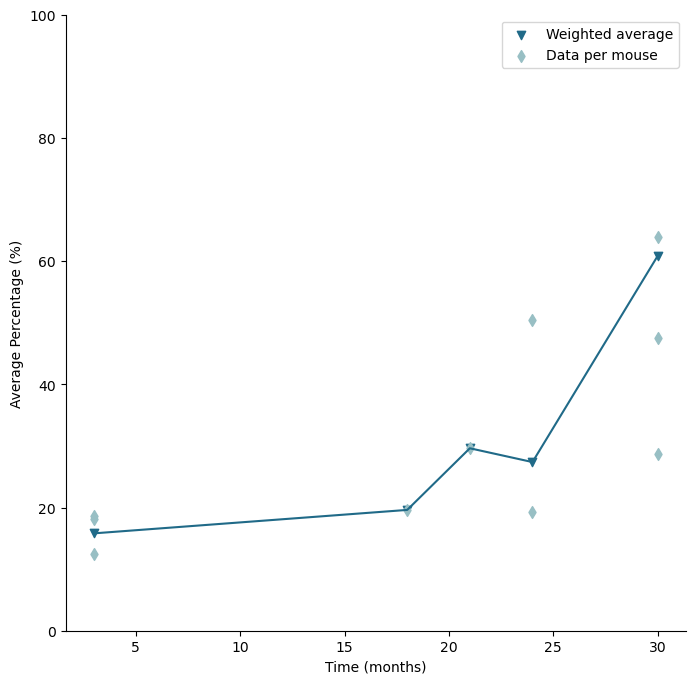

In [37]:
# reshape data
result_per_mouseT = result_per_mouse.T.reset_index()
per_mouse_ddr = result_per_mouseT[['index', 'mean']]
per_mouse_ddr.rename(columns={'mean': 'expression'}, inplace=True)
per_mouse_ddr['mouse_id'] = per_mouse_ddr['index']
per_mouse_ddr['timepoints'] = per_mouse_ddr['mouse_id'].str.split('-', n=1).str[0]
per_mouse_ddr.drop('index', inplace=True, axis = 1)


# add info: plate id, state variable, number of cells
per_mouse_ddr['plate_id'] = per_mouse_ddr.groupby('timepoints').cumcount() + 1
per_mouse_ddr['statevariable'] = 'DDR'
cell_list = []
for mouse in per_mouse_ddr['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_ddr.loc[:, 'Num_cells'] = cell_list
per_mouse_ddr.drop('mouse_id', inplace=True, axis = 1)
#print(per_mouse_ddr)

# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

per_mouse_ddr['timepoints']=  per_mouse_ddr['timepoints'].astype(int)
mean_timepoints_ddr = per_mouse_ddr.groupby('timepoints')['timepoints'].mean()
mean_expression_ddr = per_mouse_ddr.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_ddr.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_ddr = weighted_mean_expression
print(mean_expression_ddr)

# plotting
if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(mean_timepoints_ddr, weighted_mean_expression_ddr, color='#206A88', label='Weighted average', marker='v')
    plt.scatter(per_mouse_ddr['timepoints'], per_mouse_ddr['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_ddr, weighted_mean_expression_ddr, color='#206A88',linestyle='-')
    plt.xlabel('Time (months)')
    plt.ylabel('Average Percentage (%)')
    plt.legend()
    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 


2. NF-kB

In [38]:
gene_names = ['Nr2c2', 'Tab2', 'Chuk', 'Ikbkb', 'Ikbkg', 'Nfkb1', 'Rela']

In [39]:
mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

    genes_per_mouse = pd.concat([genes_per_mouse, expression_per_timepoint], ignore_index=True)

# mean of all genes per mouse
genes_per_mouse.drop(['Numeric_time', 'Gene', 'Timepoint', 'Mean', 'Std'], inplace=True, axis = 1)
result_per_mouse = genes_per_mouse.describe()
result_per_mouse

,18-F-51,21-F-54,24-M-59,30-M-3,30-M-4,30-M-5,3-F-56,3-F-57,24-M-58,3-M-8/9
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,18.224688,30.449827,43.915344,37.912088,37.500000,25.210084,20.535714,22.346369,24.624060,18.933250
std,9.025422,15.033663,11.198947,17.350642,19.094065,12.684102,13.657548,14.889430,16.252606,15.416720
min,8.155340,11.418685,25.925926,17.369727,25.000000,9.803922,7.552083,8.938547,5.263158,4.585153
25%,11.941748,21.453287,38.888889,24.162531,25.000000,16.666667,9.765625,13.687151,16.447368,9.170306
50%,17.669903,27.335640,48.148148,32.320099,25.000000,22.875817,18.750000,17.877095,21.052632,14.847162
75%,22.038835,37.889273,51.851852,54.280397,43.750000,32.679739,27.473958,25.418994,29.605263,22.925764
max,33.786408,55.709343,51.851852,58.808933,75.000000,45.098039,42.968750,51.396648,53.947368,48.908297


C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\1632648492.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_oi.rename(columns={'mean': 'expression'}, inplace=True)
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\1632648492.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_oi['mouse_id'] = per_mouse_oi['index']
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\1632648492.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

timepoints
3     20.605111
18    18.224688
21    30.449827
24    34.269702
30    33.540724
Name: expression, dtype: float64


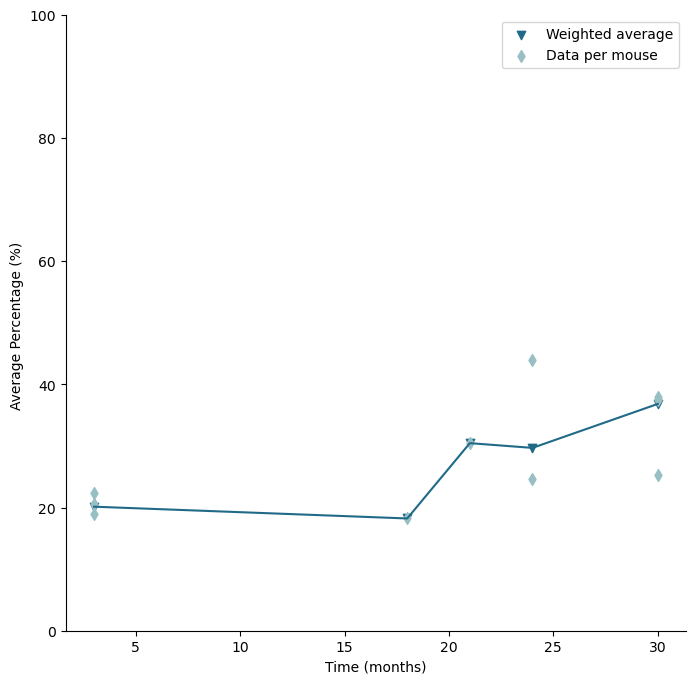

In [40]:
# reshape data
result_per_mouseT = result_per_mouse.T.reset_index()
per_mouse_oi = result_per_mouseT[['index', 'mean']]
per_mouse_oi.rename(columns={'mean': 'expression'}, inplace=True)
per_mouse_oi['mouse_id'] = per_mouse_oi['index']
per_mouse_oi['timepoints'] = per_mouse_oi['mouse_id'].str.split('-', n=1).str[0]
per_mouse_oi.drop('index', inplace=True, axis = 1)

# add info: plate id, state variable, number of cells
per_mouse_oi['plate_id'] = per_mouse_oi.groupby('timepoints').cumcount() + 1
per_mouse_oi['statevariable'] = 'OI'
cell_list = []
for mouse in per_mouse_oi['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_oi.loc[:, 'Num_cells'] = cell_list
per_mouse_oi.drop('mouse_id', inplace=True, axis = 1)

# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

per_mouse_oi['timepoints']=  per_mouse_oi['timepoints'].astype(int)
mean_timepoints_oi = per_mouse_oi.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_oi.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_oi.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_oi = weighted_mean_expression
print(mean_expression)

# plotting
if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(mean_timepoints_oi, weighted_mean_expression_oi, color='#206A88', label='Weighted average', marker='v')
    plt.scatter(per_mouse_oi['timepoints'], per_mouse_oi['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_oi, weighted_mean_expression_oi, color='#206A88',linestyle='-')
    plt.xlabel('Time (months)')
    plt.ylabel('Average Percentage (%) ')
    plt.legend()
    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 


3. SASP

In [41]:
gene_names = [ 'Ccl2', 'Ccl3',  'Ccl4', 'Cxcl2', 'Cxcl10',  'Cxcl13']

In [42]:
mouse_list = adata.obs['donor_id'].unique().tolist()
genes_per_age = pd.DataFrame(columns = ['Numeric_time'])
genes_per_mouse = pd.DataFrame(columns = ['Numeric_time'])
        
# selecting gene in dataset 
for gene_of_interest in gene_names:
    
    # extract numeric timepoints
    all_timepoints = adata.obs['age'].unique()
    timepoints_string = [str(timepoint) for timepoint in all_timepoints]
    timepoints_integer = [int(timepoint.split('m')[0]) for timepoint in timepoints_string]
    timepoints_sorted = [x for _, x in sorted(zip(timepoints_integer, all_timepoints))]

    adata_gene = adata[:, adata.var_names == gene_of_interest]
    expression_per_timepoint = pd.DataFrame(columns=['Gene', 'Timepoint', 'Numeric_time' ])

    # select timrpoint
    for timepoint in timepoints_sorted:
        adata_timepoint = adata_gene[adata_gene.obs['age'] == timepoint]
        expression_per_mouse =  pd.DataFrame(columns = ['Gene',  'Timepoint', 'Numeric_time' ])
        
        # select mouse
        for mouse in mouse_list:
            adata_mouse = adata_timepoint[adata_timepoint.obs['donor_id'] == mouse]    
            
            # make dataframe with gene expressions    
            expression_per_mouse.loc[0, 'Gene'] = gene_of_interest
            expression_per_mouse.loc[0, 'Timepoint'] = timepoint 
            expression_per_mouse['Numeric_time'] = expression_per_mouse['Timepoint'].str.split('m').str[0].astype(float)
            # calculate number of cells expressing the gene 
            expression_per_mouse[mouse] = (adata_mouse.X > 0).sum()
            # calculate total cells per mouse
            total_per_mouse = len(adata[adata.obs['donor_id'] == mouse])
            
            # calculate percentage of cells expressing the gene for cases with gene expression not 0
            if str(mouse).split('-')[0] == str(timepoint).split('m')[0] and expression_per_mouse[mouse].values[0] == 0:
                expression_per_mouse[mouse] = 0
            elif expression_per_mouse[mouse].values[0] == 0:
                    expression_per_mouse[mouse] = np.nan
            else: 
                expression_per_mouse[mouse] = expression_per_mouse[mouse] * 100 / total_per_mouse 

        # calculate mean for every timepoint (for case where there is more than 1 mouse)
        expression_per_mouse['Mean'] = expression_per_mouse.iloc[:, 3:].mean(axis=1)
        expression_per_mouse['Std'] = expression_per_mouse.iloc[:, 3:].std(axis=1)
        expression_per_timepoint = pd.concat([expression_per_timepoint, expression_per_mouse], ignore_index=True)

    genes_per_mouse = pd.concat([genes_per_mouse, expression_per_timepoint], ignore_index=True)

# mean of all genes per mouse
genes_per_mouse.drop(['Numeric_time', 'Gene', 'Timepoint', 'Mean', 'Std'], inplace=True, axis = 1)
result_per_mouse = genes_per_mouse.describe()
result_per_mouse

,18-F-51,21-F-54,24-M-59,30-M-3,30-M-4,30-M-5,3-F-56,3-F-57,24-M-58,3-M-8/9
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000
mean,10.582524,2.364475,29.629630,91.821754,20.833333,15.686275,0.564236,0.558659,0.0,0.145560
std,6.096902,1.245995,14.628458,8.761398,6.454972,9.980972,0.304439,0.611981,0.0,0.112751
min,4.077670,1.384083,3.703704,74.937965,12.500000,5.228758,0.260417,0.000000,0.0,0.000000
25%,6.359223,1.816609,25.000000,91.857940,15.625000,8.986928,0.325521,0.139665,0.0,0.054585
50%,8.834951,2.076125,35.185185,94.013648,25.000000,13.071895,0.520833,0.558659,0.0,0.218341
75%,14.660194,2.076125,37.037037,96.401985,25.000000,20.588235,0.716146,0.558659,0.0,0.218341
max,19.611650,4.844291,44.444444,99.627792,25.000000,32.026144,1.041667,1.675978,0.0,0.218341


C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\2941757498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ia.rename(columns={'mean': 'expression'}, inplace=True)
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\2941757498.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per_mouse_ia['mouse_id'] = per_mouse_ia['index']
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\2941757498.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

timepoints
3      0.422819
18    10.582524
21     2.364475
24    14.814815
30    42.780454
Name: expression, dtype: float64


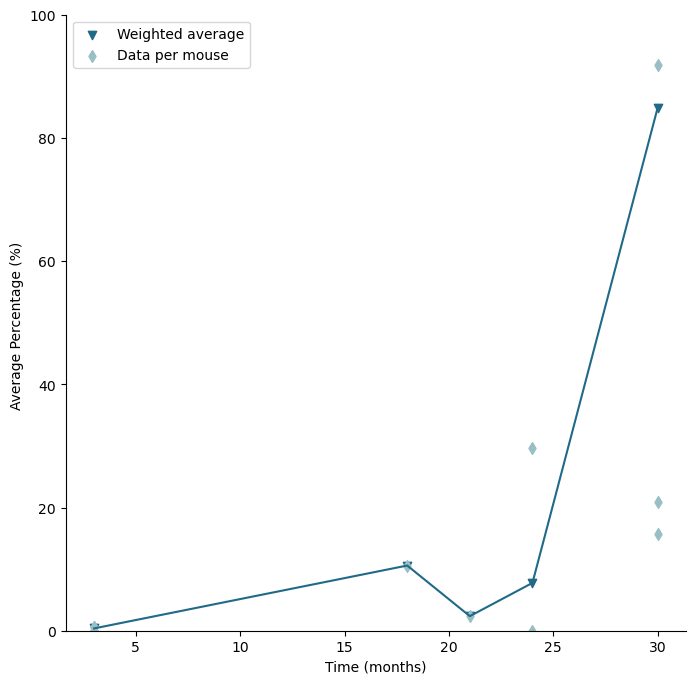

In [43]:
# reshape data
result_per_mouseT = result_per_mouse.T.reset_index()
per_mouse_ia = result_per_mouseT[['index', 'mean']]
per_mouse_ia.rename(columns={'mean': 'expression'}, inplace=True)
per_mouse_ia['mouse_id'] = per_mouse_ia['index']
per_mouse_ia['timepoints'] = per_mouse_ia['mouse_id'].str.split('-', n=1).str[0]
per_mouse_ia.drop('index', inplace=True, axis = 1)

# add info: plate id, state variable, number of cells
per_mouse_ia['plate_id'] = per_mouse_ia.groupby('timepoints').cumcount() + 1
per_mouse_ia['statevariable'] = 'IA'
cell_list = []
for mouse in per_mouse_ia['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_ia.loc[:, 'Num_cells'] = cell_list
per_mouse_ia.drop('mouse_id', inplace=True, axis = 1)

# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

per_mouse_ia['timepoints']=  per_mouse_ia['timepoints'].astype(int)
mean_timepoints_ia = per_mouse_ia.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_ia.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_ia.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_ia = weighted_mean_expression
print(mean_expression)

# plotting
if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.scatter(mean_timepoints_ia, weighted_mean_expression_ia, color='#206A88', label='Weighted average', marker='v')
    plt.scatter(per_mouse_ia['timepoints'], per_mouse_ia['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_ia, weighted_mean_expression_ia, color='#206A88',linestyle='-')
    plt.xlabel('Time (months)')
    plt.ylabel('Average Percentage (%) ')
    plt.legend()
    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 


4. Senescence 

In [44]:
# reshape data
per_mouse_sen = pd.DataFrame(index = ['mouse_id'])
per_mouse_sen.index = adata.obs['donor_id'].unique()
per_mouse_sen['expression'] = adata.obs.groupby('donor_id')['sen_score_combined'].mean()
per_mouse_sen.reset_index(drop = False, inplace=True)
per_mouse_sen.rename(columns = {'index': 'mouse_id'}, inplace=True)
per_mouse_sen['timepoints'] = per_mouse_sen['mouse_id'].str.split('-', n=1).str[0].astype(int)


# add info: plate id, state variable, number of cells
per_mouse_sen['plate_id'] = per_mouse_sen.groupby('timepoints').cumcount() + 1
per_mouse_sen['statevariable'] = 'SC'
cell_list = []

for mouse in per_mouse_sen['mouse_id']:
    cell_number = len(adata[adata.obs['donor_id'] == mouse])
    cell_list.append(cell_number)
per_mouse_sen.loc[:, 'Num_cells'] = cell_list
per_mouse_sen.drop('mouse_id', axis = 1, inplace=True)

per_mouse_sen

,expression,timepoints,plate_id,statevariable,Num_cells
0,3.009547,18,1,SC,515
1,4.562750,21,1,SC,289
2,10.828179,24,1,SC,27
3,13.318953,30,1,SC,1612
4,1.126985,30,2,SC,8
5,3.688394,30,3,SC,153
6,2.159194,3,1,SC,384
7,2.355426,3,2,SC,179
8,4.088668,24,2,SC,76
9,1.823370,3,3,SC,458


timepoints
3     2.112663
18    3.009547
21    4.562750
24    7.458424
30    6.044777
Name: expression, dtype: float64


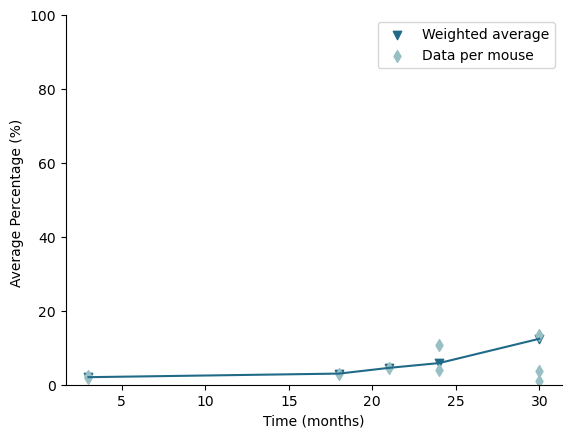

In [45]:
# calculate weighted average based on total number of cells per mouse 
def weighted_average(group):
    return np.average(group['expression'], weights=group['Num_cells'])

# plotting
per_mouse_sen['timepoints']=  per_mouse_sen['timepoints'].astype(int)
mean_timepoints_sc = per_mouse_sen.groupby('timepoints')['timepoints'].mean()
mean_expression = per_mouse_sen.groupby('timepoints')['expression'].mean()
weighted_mean_expression = per_mouse_sen.groupby('timepoints').apply(weighted_average).reset_index(drop=True)
weighted_mean_expression_sc = weighted_mean_expression
print(mean_expression)

if show:
    plt.scatter(mean_timepoints_sc, weighted_mean_expression_sc, color='#206A88', label='Weighted average', marker='v')
    plt.scatter(per_mouse_sen['timepoints'], per_mouse_sen['expression'], color = '#98BFC4', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_sc, weighted_mean_expression_sc, color='#206A88',linestyle='-')
    plt.xlabel('Time (months)')
    plt.ylabel('Average Percentage (%) ')
    plt.legend()
    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    plt.show()

5. Merge data and add insert theoretical dose

In [46]:
# fuse dataframes and save as csv for parameter fitting
all_pathways_activities = pd.concat([per_mouse_ddr, per_mouse_oi, per_mouse_ia, per_mouse_sen], ignore_index=True, sort=False)

# add one dose or more doses
all_pathways_activities0 = all_pathways_activities.copy()
all_pathways_activities05 = all_pathways_activities.copy()
all_pathways_activities0['concentration'] = 0
all_pathways_activities05['concentration'] = 0.5

all_pathways_activities_merge = pd.concat([all_pathways_activities0, all_pathways_activities05], axis = 0)
all_pathways_activities_merge['timepoints'] = all_pathways_activities_merge['timepoints'].astype(int)
all_pathways_activities_merge = all_pathways_activities_merge[['statevariable', 'plate_id', 'concentration', 'timepoints','expression', 'Num_cells' ]]
all_pathways_activities_merge = all_pathways_activities_merge.sort_values(by= ['statevariable', 'concentration', 'timepoints'])
all_pathways_activities_merge[40:60]

,statevariable,plate_id,concentration,timepoints,expression,Num_cells
16,OI,1,0.0,3,20.535714,384
17,OI,2,0.0,3,22.346369,179
19,OI,3,0.0,3,18.933250,458
10,OI,1,0.0,18,18.224688,515
11,OI,1,0.0,21,30.449827,289
12,OI,1,0.0,24,43.915344,27
18,OI,2,0.0,24,24.624060,76
13,OI,1,0.0,30,37.912088,1612
14,OI,2,0.0,30,37.500000,8
15,OI,3,0.0,30,25.210084,153


6. Insert empty replicates

In [47]:
# count how many replicates there are initially
all_pathways_activities_merge['counting'] = all_pathways_activities_merge.apply(
    lambda row: str(row['statevariable']) + str(row['concentration']) + str(row['timepoints']),
    axis=1)

num_replicates = all_pathways_activities_merge.groupby('counting').size()
all_pathways_activities_merge['count_values'] = all_pathways_activities_merge['counting'].map(num_replicates)
all_pathways_activities_merge.reset_index(drop= True, inplace=True)

# where count is 3, no replicate has to be added

# dublicate a row where count is 2
selected_rows_double = all_pathways_activities_merge[(all_pathways_activities_merge['plate_id'] == 2) & (all_pathways_activities_merge['count_values'] == 2)].copy()
selected_rows_double['expression'] = pd.NA
selected_rows_double['flag'] = 'done'
merged_double = pd.concat([all_pathways_activities_merge, selected_rows_double], ignore_index=True)

# dublicate a row where count is 1 to get 2
selected_rows_single_1 = merged_double[(merged_double['plate_id'] == 1) & (merged_double['count_values'] == 1) & (merged_double['flag'] != 'done') ].copy()
selected_rows_single_1['expression'] = pd.NA
selected_rows_single_1['flag'] = 'done'
merged_single_1 = pd.concat([merged_double, selected_rows_single_1], ignore_index=True)

# dublicate another row where count is 1 to get 3
selected_rows_single_2 = merged_single_1[(merged_single_1['plate_id'] == 1) & (merged_single_1['count_values'] == 1) & (merged_double['flag'] != 'done') ].copy()
selected_rows_single_2['expression'] = pd.NA
selected_rows_single_2['flag'] = 'done'
merged_single_2 = pd.concat([merged_single_1, selected_rows_single_2], ignore_index=True)


inflated_data = merged_single_2.drop(['plate_id'], axis=1)
inflated_data.sort_values(['statevariable', 'concentration'], inplace= True)

# seperate for grouping
inflated_ddr =inflated_data[inflated_data['statevariable'] == 'DDR']
inflated_oi =inflated_data[inflated_data['statevariable'] == 'OI']
inflated_ia =inflated_data[inflated_data['statevariable'] == 'IA']
inflated_sc =inflated_data[inflated_data['statevariable'] == 'SC']

# add new plate ids
inflated_ddr['plate_id'] = inflated_ddr.groupby(['concentration', 'timepoints']).cumcount() + 1
inflated_oi['plate_id'] = inflated_oi.groupby(['concentration', 'timepoints']).cumcount() + 1
inflated_ia['plate_id'] = inflated_ia.groupby(['concentration', 'timepoints']).cumcount() + 1
inflated_sc['plate_id'] = inflated_sc.groupby(['concentration', 'timepoints']).cumcount() + 1

inflated_data = pd.concat([inflated_ddr,inflated_oi, inflated_ia, inflated_sc])

# sort
inflated_data = inflated_data[['statevariable', 'plate_id', 'concentration', 'timepoints', 'expression', 'Num_cells']]
inflated_data.sort_values(['statevariable', 'plate_id', 'concentration', 'timepoints'], inplace= True)
inflated_data.shape

C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\630170982.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflated_ddr['plate_id'] = inflated_ddr.groupby(['concentration', 'timepoints']).cumcount() + 1
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\630170982.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflated_oi['plate_id'] = inflated_oi.groupby(['concentration', 'timepoints']).cumcount() + 1
C:\Users\Helene\AppData\Local\Temp\ipykernel_40312\630170982.py:43: SettingWithCopyWarning: 
A

(120, 6)

7. Scaling

In [48]:
# determine highest value
max_ddr = inflated_data.loc[inflated_data['statevariable'] == 'DDR', 'expression'].max()
max_oi = inflated_data.loc[inflated_data['statevariable'] == 'OI', 'expression'].max()
max_ia = inflated_data.loc[inflated_data['statevariable'] == 'IA', 'expression'].max()
max_sc = inflated_data.loc[inflated_data['statevariable'] == 'SC', 'expression'].max()

print(max_ia)

# calculate scaling factors
factor_ddr = max_ia/max_ddr
factor_oi = max_ia/max_oi
factor_sc = max_ia/max_sc
factor_ia = 1
print(factor_ddr)
# apply scaling factor
inflated_data.loc[inflated_data['statevariable'] == 'DDR', 'expression'] = inflated_data.loc[inflated_data['statevariable'] == 'DDR', 'expression']*factor_ddr
inflated_data.loc[inflated_data['statevariable'] == 'OI', 'expression'] = inflated_data.loc[inflated_data['statevariable'] == 'OI', 'expression']*factor_oi
inflated_data.loc[inflated_data['statevariable'] == 'SC', 'expression'] = inflated_data.loc[inflated_data['statevariable'] == 'SC', 'expression']*factor_sc
#print(inflated_data[28:-30])
inflated_data[80:100]
inflated_data[inflated_data['timepoints'] == 3]

91.8217535153019
1.4353827256271012


,statevariable,plate_id,concentration,timepoints,expression,Num_cells
0,DDR,1,0.0,3,26.763907,384
10,DDR,1,0.5,3,26.763907,384
1,DDR,2,0.0,3,26.141607,179
11,DDR,2,0.5,3,26.141607,179
2,DDR,3,0.0,3,17.926614,458
12,DDR,3,0.5,3,17.926614,458
20,IA,1,0.0,3,0.564236,384
30,IA,1,0.5,3,0.564236,384
21,IA,2,0.0,3,0.558659,179
31,IA,2,0.5,3,0.558659,179


Plot scaled data

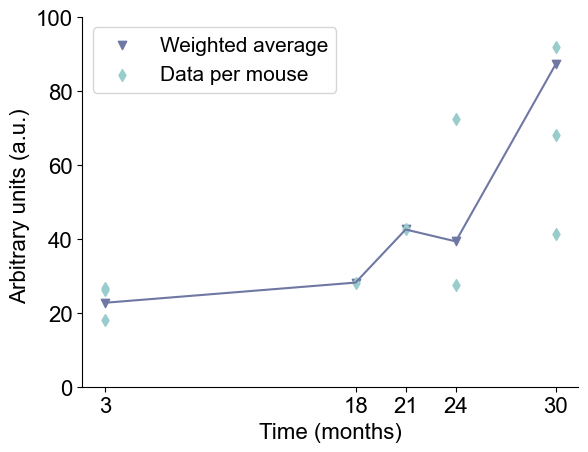

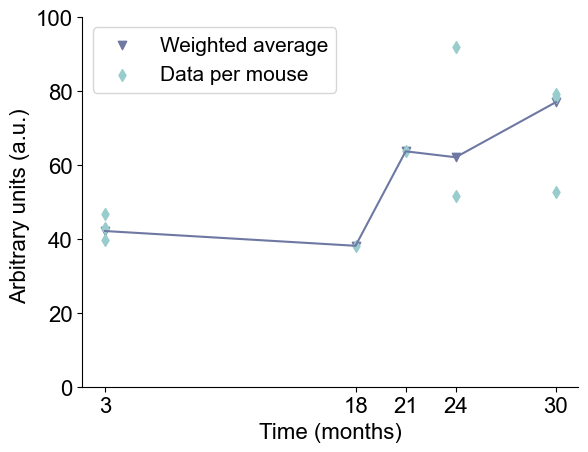

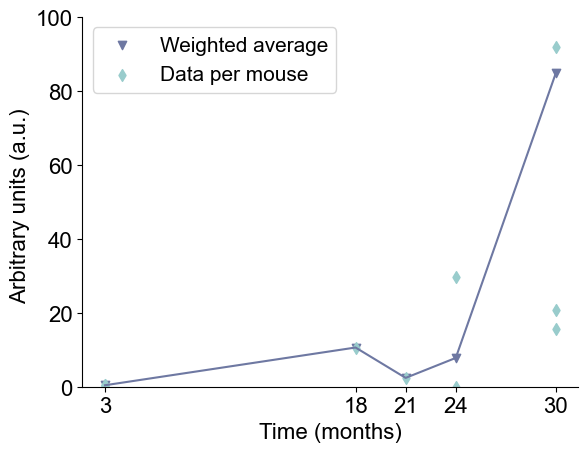

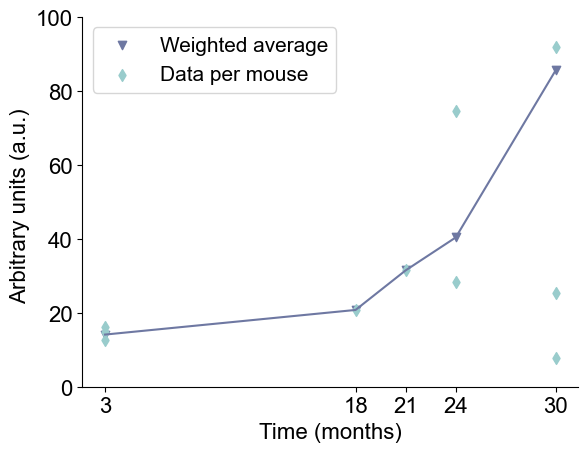

In [51]:

weighted_mean_expression_ddr_scaled = weighted_mean_expression_ddr * factor_ddr
weighted_mean_expression_oi_scaled = weighted_mean_expression_oi * factor_oi
weighted_mean_expression_sc_scaled = weighted_mean_expression_sc * factor_sc
per_mouse_ddr['expression_scaled'] = per_mouse_ddr['expression'] * factor_ddr
per_mouse_oi['expression_scaled'] = per_mouse_oi['expression'] * factor_oi
per_mouse_sen['expression_scaled'] = per_mouse_sen['expression'] * factor_sc

if show:
     # ddr
    plt.scatter(mean_timepoints_ddr, weighted_mean_expression_ddr_scaled, color='#6E78A2', label='Weighted average', marker='v')
    plt.scatter(per_mouse_ddr['timepoints'], per_mouse_ddr['expression_scaled'], color = '#99CCCC', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_ddr, weighted_mean_expression_ddr_scaled, color='#6E78A2',linestyle='-')
    plt.xlabel('Time (months)', fontsize=16, fontfamily='arial')
    plt.ylabel('Arbitrary units (a.u.) ', fontsize=16, fontfamily='arial')
    plt.xticks([3, 18, 21, 24, 30], fontsize=16, fontfamily='arial')
    plt.yticks(fontsize=16, fontfamily='arial')
    plt.legend(loc= 'upper left', prop={'family': 'arial', 'size': 15})

    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    plt.show()
     # oi
    plt.scatter(mean_timepoints_oi, weighted_mean_expression_oi_scaled, color='#6E78A2', label='Weighted average', marker='v')
    plt.scatter(per_mouse_oi['timepoints'], per_mouse_oi['expression_scaled'], color = '#99CCCC', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_oi, weighted_mean_expression_oi_scaled, color='#6E78A2',linestyle='-')
    plt.xlabel('Time (months)', fontsize=16, fontfamily='arial')
    plt.ylabel('Arbitrary units (a.u.) ', fontsize=16, fontfamily='arial')
    plt.xticks([3, 18, 21, 24, 30], fontsize=16, fontfamily='arial')
    plt.yticks(fontsize=16, fontfamily='arial')
    plt.legend(loc= 'upper left', prop={'family': 'arial', 'size': 15})

    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    plt.show()
    # ia
    plt.scatter(mean_timepoints_ia, weighted_mean_expression_ia, color='#6E78A2', label='Weighted average', marker='v')
    plt.scatter(per_mouse_ia['timepoints'], per_mouse_ia['expression'], color = '#99CCCC', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_ia, weighted_mean_expression_ia, color='#6E78A2',linestyle='-')
    plt.xlabel('Time (months)', fontsize=16, fontfamily='arial')
    plt.ylabel('Arbitrary units (a.u.) ', fontsize=16, fontfamily='arial')
    plt.xticks([3, 18, 21, 24, 30], fontsize=16, fontfamily='arial')
    plt.yticks(fontsize=16, fontfamily='arial')
    plt.legend(loc= 'upper left', prop={'family': 'arial', 'size': 15})
 
    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    plt.show()

    # sc
    plt.scatter(mean_timepoints_sc, weighted_mean_expression_sc_scaled, color='#6E78A2', label='Weighted average', marker='v')
    plt.scatter(per_mouse_sen['timepoints'], per_mouse_sen['expression_scaled'], color = '#99CCCC', label='Data per mouse', marker='d' )
    plt.plot(mean_timepoints_sc, weighted_mean_expression_sc_scaled, color='#6E78A2',linestyle='-')
    plt.xlabel('Time (months)', fontsize=16, fontfamily='arial')
    plt.ylabel('Arbitrary units (a.u.) ', fontsize=16, fontfamily='arial')
    plt.xticks([3, 18, 21, 24, 30], fontsize=16, fontfamily='arial')
    plt.yticks(fontsize=16, fontfamily='arial')
    plt.legend(loc= 'upper left', prop={'family': 'arial', 'size': 15})
    ax = plt.gca() 
    ax.set_ylim([0, 100])
    ax.spines['top'].set_visible(False) 
    ax.spines['right'].set_visible(False) 
    plt.show()

Export data

In [50]:
# exprot as csv
pathway_csv = inflated_data.to_csv('C:/Users/Helene/Documents/Master_Thesis/ODE/Model_2.8.0_07.02./pathwaydata.csv', index = False, na_rep='NA') 